In [1]:
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
from scipy.stats import mode
import csv
import matplotlib.dates
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from datetime import *

%matplotlib inline

In [4]:
# 导入数据
df = pd.read_csv('./data/train_20171215.txt', sep='\t')

print(df.info())
print(df.describe())
print(df.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4773 entries, 0 to 4772
Data columns (total 4 columns):
date           4773 non-null int64
day_of_week    4773 non-null int64
brand          4773 non-null int64
cnt            4773 non-null int64
dtypes: int64(4)
memory usage: 149.2 KB
None
              date  day_of_week        brand          cnt
count  4773.000000  4773.000000  4773.000000  4773.000000
mean    524.399749     3.512047     2.990153   380.567358
std     297.546919     1.738846     1.417509   252.720918
min       1.000000     1.000000     1.000000    12.000000
25%     271.000000     2.000000     2.000000   221.000000
50%     529.000000     3.000000     3.000000   351.000000
75%     781.000000     5.000000     4.000000   496.000000
max    1032.000000     7.000000     5.000000  2102.000000
   date  day_of_week  brand   cnt
0     1            3      1    20
1     1            3      5    48
2     2            4      1    16
3     2            4      3    20
4     3          

/home/qy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  after removing the cwd from sys.path.


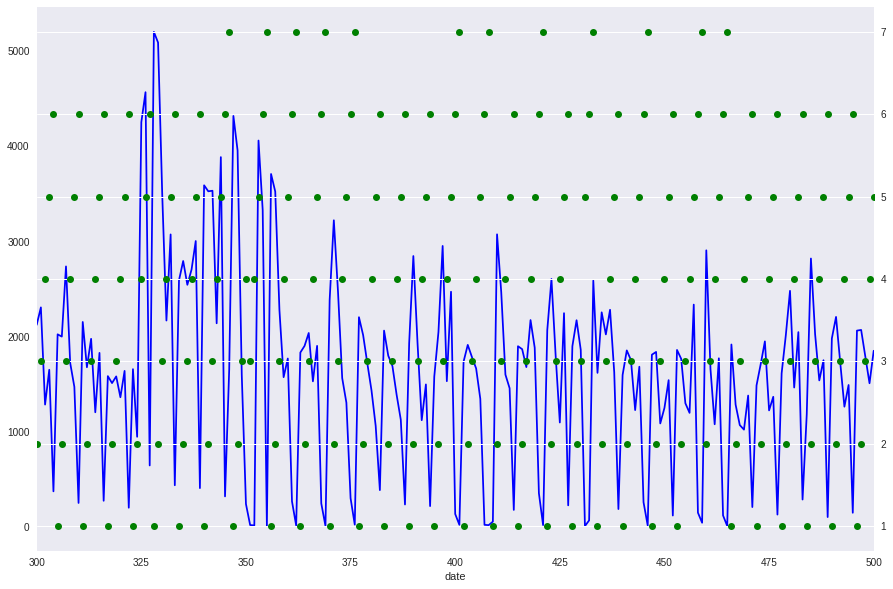

In [40]:
# 日期与上排量曲线
dataDf = pd.pivot_table(df,index=["date"], values=["cnt","day_of_week"], aggfunc={"cnt":np.sum, "day_of_week": np.max})
fig, ax = plt.subplots(figsize=(15,10))
dataDf.ix[300:500, 'cnt'].plot(ax=ax, style='b-')
dataDf.ix[300:500, 'day_of_week'].plot(ax=ax, style='go', secondary_y=True)